# Modifying the Default Values for Surface Error and Aperture Efficiency

We encourage users of the GBT to rely on the Observatory-measured values and functions for surface error and aperture efficiency, which are implemented in `dysh`.   However, advanced users may wish to modify the values or functions; this example shows how to do that.


## Refresher on Aperture Efficiency and Brightness Scales
The aperture efficiency $\eta_a$ is determined by:

$$\eta_a = \eta_0~G(ZD) \exp(-(4\pi\epsilon/\lambda)^2),$$

where $\eta_0$ is the long wavelength aperture efficiency, $G(ZD)$ is the gain correction factor
at a zenith distance $ZD$, $\epsilon$ is the surface error, and $\lambda$ is the wavelength.

To scale antenna temperature $T_a$ to brightness tempeature $T_a^*$:

$$ T_a^* = T_a~\exp(\tau~A)/(\eta_a~\eta_l),$$

where $\tau$ is the zenith opacity, $A$ is the airmass, and $\eta_l$ is the loss efficiency.  To scale to flux $S_\nu$

$$ S_\nu = 2~k~T_a^*/A_p, $$

where $k$ is Boltzmann's constant is $A_p$ is the physical aperture of the telescope. 




## What `dysh` Does

When you calibrate and scale data through, e.g. 
[GBTFITSLoad.getps](https://dysh.readthedocs.io/en/latest/reference/modules/dysh.fits.html#dysh.fits.GBTFITSLoad.getps),
`dysh` uses the `GBTGainCorrection` class to manage the calculations described above. `GBTGainCorrection` maintains $G(ZD)$ and surface error as a function of date as derived in 
[GBT Memo 301](https://library.nrao.edu/public/memos/gbt/GBT_301.pdf). 
You can provide your own values for $\eta_a$ or $\epsilon$ in the standard calibration routines (you must provide $\tau$).


## Loading Modules
We start by loading the modules we will use for the data reduction. 

For display purposes, we use the static (non-interactive) `matplotlib` backend in this tutorial. However, you can tell `matplotlib` to use the `ipympl` backend to enable interactive plots. This is only needed if working on `jupyter` lab or notebook.

In [1]:
# Set interactive plots in jupyter.
#%matplotlib ipympl

# These modules are required for the data reduction.
from dysh.fits.gbtfitsload import GBTFITSLoad
from astropy import units as u
import numpy as np
from dysh.log import init_logging

# These modules are used for file I/O
from dysh.util.files import dysh_data
from pathlib import Path

Set the logging level to INFO.

In [2]:
init_logging(2)

## Data Retrieval

Download the example SDFITS data, if necessary.

In [3]:
filename = dysh_data(test="getps")

21:14:30.384 I Resolving test=getps -> AGBT05B_047_01/AGBT05B_047_01.raw.acs/


## Data Loading

Next, we use `GBTFITSLoad` to load the data, and then its `summary` method to inspect its contents.

In [4]:
sdfits = GBTFITSLoad(filename)

In [5]:
sdfits.summary()

SCAN,OBJECT,VELOCITY,PROC,PROCSEQN,RESTFREQ,DOPFREQ,# IF,# POL,# INT,# FEED,AZIMUTH,ELEVATION
51,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,2,11,1,198.3431,18.6427
52,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,2,11,1,198.9306,18.7872
53,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,2,11,1,199.3305,18.3561
54,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,2,11,1,199.9157,18.4927
55,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,2,11,1,200.3042,18.0575
56,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,2,11,1,200.8906,18.1860
57,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,2,11,1,202.3275,17.3853
58,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,2,11,1,202.9192,17.4949


## Data Reduction
We calibrate a few scans of the position switched observations, giving a value for `zenith_opacity` but leaving `dysh` to calculate the aperture efficiency.
We will calibrate scans 51, 53 and 55.
We use a zenith opacity of 0.08, but the exact values is not important here.
And, we request that the data be calibrated to units of flux, so that the aperture efficiency goes into the calculations.

In [6]:
scans = [51,53,55]

In [7]:
ps_scan_block = sdfits.getps(scan=scans, ifnum=0, plnum=0, fdnum=0, units="flux", 
                             zenith_opacity=0.08)

### Providing Aperture Efficiency or Surface Error

Now, we calibrate the same data, but we provide a value for the aperture efficiency.
We use a value of $25\%$ (``ap_eff=0.25``).

In [8]:
ps_scan_block_ap_eff = sdfits.getps(scan=scans, ifnum=0, plnum=0, fdnum=0, units="flux", 
                                    zenith_opacity=0.08, ap_eff=0.25)

Alternatively, one could specify the surface error using the ``surface_error`` argument.
The value of the ``surface_error`` must be a quantity with units compatible with a length.
(You can't give both surface error and aperture efficiency because the latter is computed from the former.)

In [9]:
ps_scan_block_surf_err = sdfits.getps(scan=scans, ifnum=0, plnum=0, fdnum=0, units="flux", 
                                      zenith_opacity=0.08, surface_error=400*u.micron)

Now we print the different $\eta_a$ for the first scan in each ``ScanBlock``.
You can see that at this wavelength, the surface error does not have much of an effect because $\epsilon << \lambda$. (400 $\mu$m vs. 21 cm)

In [10]:
print(f"{np.mean(ps_scan_block[0].ap_eff):.4f},{np.mean(ps_scan_block_ap_eff[0].ap_eff):.4f},{np.mean(ps_scan_block_surf_err[0].ap_eff):.4f}")

0.7047,0.2500,0.7045


But the aperture efficiency does make a different in the derived flux.

S_nu = 0.18 Jy


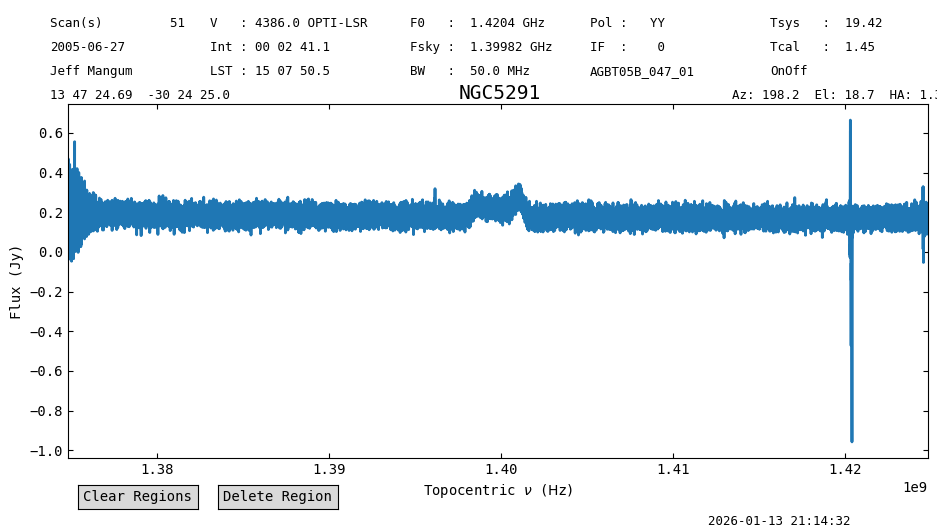

In [11]:
a = ps_scan_block.timeaverage()
print(f"S_nu = {a.stats()['median']:.3}")
a.plot()

S_nu = 0.508 Jy


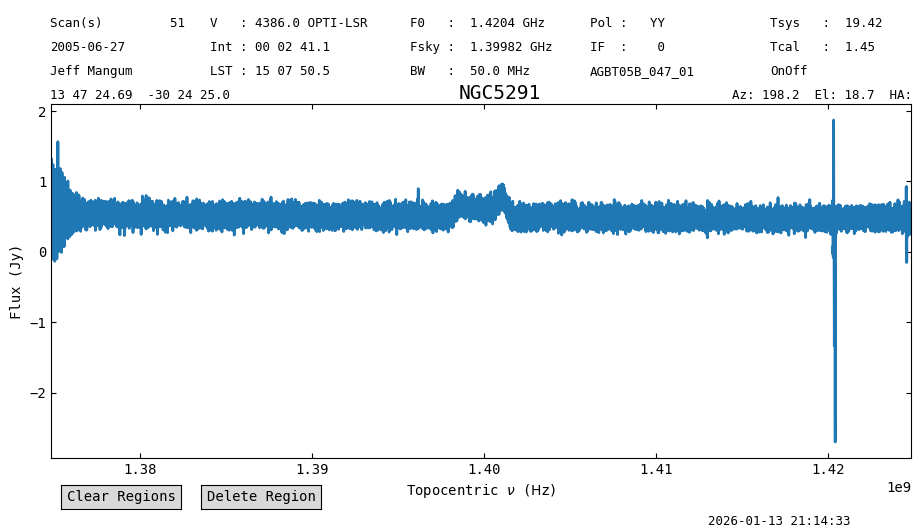

In [12]:
b = ps_scan_block_ap_eff.timeaverage()
print(f"S_nu = {b.stats()['median']:.3}")
b.plot()

The weighted average aperture efficiency, surface error, and zenith opacity are stored in the ``Spectrum`` metadata.

In [13]:
print(f"eta = {a.meta['AP_EFF']:.3f}, epsilon = {a.meta['SURF_ERR']:.1f} {a.meta['SE_UNIT']}, tau = {a.meta['TAU_Z']:.2f}")

eta = 0.705, epsilon = 230.0 micron, tau = 0.08


## What if I want to change $G(ZD)$ or the surface error model?
This is advanced usage and requires you to fork or clone ``dysh``, then modify ``src/dysh/data/gaincorrection.tab``. If you have questions, consult with a ``dysh`` developer. 

## Final Stats

Finally, at the end we compute some statistics over a spectrum, merely as a checksum if the notebook is reproducable.

In [14]:
b.stats() # rms 0.11950689 Jy

{'mean': <Quantity 0.51000153 Jy>,
 'median': <Quantity 0.50791217 Jy>,
 'rms': <Quantity 0.11950689 Jy>,
 'min': <Quantity -2.69882719 Jy>,
 'max': <Quantity 1.87220354 Jy>,
 'npt': 32768,
 'nan': 0}